# ПРОЕКТ: ТЕЛЕКОМ

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

### Задачи проекта

- Разработать модели для прогнозирования оттока клиента (бинарная классификация)
- Выбрать лучшую модель по результатам кросс-валидации
- Провести тестирование лучшей модели и получить метрику качества __ROC-AUC__ не ниже __0.85__
- Оценить важность признаков

### Краткий план работы

| **№ п/п** | **Задача** | **Срок выполнения** |
| :---: | :--- | :---: |
|1.|Импортировать необходимые библиотеки. Загрузить данные. Провести их осмотр.|01.04.2025|
|2.|Провести предобработку данных. Принять решение по обработке пропусков.|01.04.2025|
|3.|Провести исследовательский и корелляционный анализ данных.|02.04.2025|
|4.|Провести подготовку данных. Отобрать признаки.|03.04.2025|
|5.|Подобрать гиперпараметры и обучить модели. Выбрать лучшую модель по результатам кросс-валидации.|04.04.2025|
|6.|Получить прогнозы для лучшей модели на тестовой выборке. Провести оценку качества ML-модели по метрике ROC-AUC.|07.04.2025|
|7.|Оценить важность признаков.|08.04.2025|
|8.|Сформулировать выводы и рекомендации.|08.04.2025|


## Импорт библиотек

In [20]:
import os
import urllib
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import tensorflow as tf # для построение полносвязной нейросети
import shap # инструмент для оценки важности признаков
import logging

# инструменты деления выборки и кросс-валидации
from sklearn.model_selection import train_test_split, StratifiedKFold

# импортируем функции для работы с метриками оценки качества
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# инструменты для подготовки данных
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder

# импортируем нужные модели
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# классы для построения нейросети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Input 
from tensorflow.keras.initializers import RandomNormal

# библиотека для работы с корреляцией признаков
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# инструмент для подбора гиперпараметров
import optuna
from optuna.integration import OptunaSearchCV

# библиотека для работы с базой данных
from sqlalchemy import create_engine, text

# устанавливаем тему для графиков
sns.set_theme(style="whitegrid")
palette = {0: 'lightgray', 1: 'darkred'}

RANDOM_STATE = 42
TEST_SIZE = 0.25
BATCH_SIZE = 32
EPOCH_NUM = 50
LR = 1e-2
CV_N_SPLITS = 5 # для кросс-валидации на 5 фолдов

# название файла базы данных и контрольная сумма
DB_FILENAME = 'ds-plus-final.db' 
DB_FILE_SHA256 = '391dbe5a32c03a5c2bc1612ac803c24dba5aa95e636b89f42a5ff9c463b1c569'

# фиксация генераторов случайных чисел для воспроизводимости
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [21]:
# функция для проверки целостности файла
def is_file_valid(filename, check_sum):
    sha256 = hashlib.sha256()
    with open(filename, "rb") as f: # открываем файл в двоичном режиме (rb)
        for block in iter(lambda: f.read(4096), b""):
            sha256.update(block)
    return sha256.hexdigest() == check_sum

In [22]:
# проверка, существует ли файл в текущей папке проекта
# и его целостности
if os.path.exists(DB_FILENAME) and is_file_valid(DB_FILENAME, DB_FILE_SHA256):
    print(f'Файл базы данных {DB_FILENAME} существует. Целостность проверена.')
    pass
else:
    print(f'Файл {DB_FILENAME} не найден, загружаем...')
    url = f'https://code.s3.yandex.net/data-scientist/{DB_FILENAME}'
    urllib.request.urlretrieve(url, DB_FILENAME)
    print(f'Файл успешно загружен.')

Файл базы данных ds-plus-final.db существует. Целостность проверена.


In [23]:
# создание строки конфигурации подключения
# и и объекта подключения к БД
db_config = f'sqlite:///{DB_FILENAME}'
engine = create_engine(db_config, echo=False) 

## Определение некотрых переиспользуемых функций

### Функция выполнения SQL-запросов внутри connection-блока

In [24]:
# принимает на вход "движок" и функцию запроса
def execute_with_db_connection(db_engine, func):
    with db_engine.connect() as connection: # гарантирует закрытие соединения
        try:
            result = func(connection) # вызов func с sql-запросом
            print("✅ Успешное подключение к базе данных")
            return result # возвращает результат в виде pandas-таблицы
        except Exception as e:
            print(f"❌ Ошибка подключения: {e}")
    pass

### Функция для вывода диаграммы размаха

In [25]:
def print_boxplot(data, title='Диаграмма размаха', x_label=''):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.boxplot(data=data, orient='h', ax=ax)
    if x_label != '':
        ax.set_xlabel(x_label)
    fig.suptitle(title, fontsize=14, fontweight='bold')
    sns.despine(left=True)
    fig.tight_layout()
    plt.show()

### Функция для вывода количественной диаграммы

In [26]:
def print_counts(df, col_name, title=None, y_label='Значение признака'):
    # задаем количество областей для рисования и их размеры
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.countplot(
        data=df,
        y=col_name,
        orient='h',
        hue='target',
        palette=palette,
        # устанавливаем цвет и порядок по убыванию сверху вниз
        order=df[col_name].value_counts().index,
        ax=ax
    )

    # подписываем оси и названия
    ax.set_xlabel('Количество наблюдений')
    ax.set_ylabel(y_label)
    ax.legend(title='Таргет (отток клиента)', labels=['Останется (0)', 'Уйдет (1)'])

    # выводим название для графиков
    fig.suptitle(title, fontsize=14, fontweight='bold')    

    # код для вывода процентов
    # массив для общего количества значений в категории для каждого столбика
    counts = np.tile( 
        df[col_name].value_counts().values, 
        df['target'].nunique() # количество повторений для каждого hue
    )

    # отфильтровываем нулевые patches
    actual_patches = [p for p in ax.patches if p.get_width() > 0]

    # подписываем проценты для каждого столбика
    for i, p in enumerate(actual_patches):
        total = counts[i]
        x = p.get_width()
        y = p.get_y() + p.get_height()
        annot = f' {(x / total):.0%}'
        ax.annotate(annot, (x, y), fontsize=10)
        pass

    # убираем лишнее
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

### Функция для вывода распределения количественных переменных

In [27]:
# функция принимает на вход датасет, название колонки
# и другие элементы
def print_distribution_density(df, col_name,
                       title=None,
                       x_label=None,
                       hue=None):
    # задаем область рисования
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.kdeplot(
        data=df,
        x=col_name,
        hue=hue, # делим по целевой переменной
        palette=palette,
        multiple='layer',
        fill=True,
        common_norm=False,
        ax=ax
    )

    # подписываем оси
    ax.set_xlabel(x_label)
    ax.set_ylabel('Плотность распределения')

    # подписываем название графика
    fig.suptitle(title, fontsize=12, fontweight='bold')

    # убираем лишнее
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

### Функция для вывода круговой диаграммы

In [28]:
def print_pie(data, title=None, startangle=0):
    # определяем функцию для возврата процентов
    # для подписей на круговой диаграмме
    def get_percent_with_count(percent, allvals):
        absolute = int(np.round(percent/100.*np.sum(allvals)))
        return f"{percent:.1f}%\n({absolute:d} клиентов)"
    
    plt.pie(
        data.value_counts(), # передаем количество клиентов
        # устанавливаем подписи к данным
        autopct=lambda percent: get_percent_with_count(percent, data.value_counts()),
        # устанавливаем угол поворота
        startangle=startangle,
        # устанавливаем цвета для категорий
        colors = list(palette.values()),
        pctdistance=1.5
    )
    
    # устанавливаем название графика
    plt.suptitle(title, fontsize=14, fontweight='bold')
    # настройка легенды
    labels = ['Не уйдет (0)', 'Уйдет (1)']
    plt.legend(labels, title='Таргет (отток клиентов)', loc='upper right')
    plt.tight_layout()
    plt.show()
    pass

### Функция для вывода матрицы корреляции

In [29]:
# функция принимает датасет и список количественных признаков
def plot_corr(df, interval_cols):
    # считаем корреляции
    phik_overview = phik_matrix(
        df,
        interval_cols=interval_cols
    )
    # визуализируем матрицу корреляции
    plot_correlation_matrix(
        # передаём значения матрицы корреляции
        phik_overview.values,
        
        # указываем наименования столбцов
        x_labels=phik_overview.columns,
        
        # указываем наименования строк
        y_labels=phik_overview.index,
        
        # указываем цвет градиентной отрисовки
        vmin=0, vmax=1, color_map='Greens',
        
        # добавляем заголовок
        title=r'correlation $\phi_K$',
        
        # увеличиваем размер шрифта
        fontsize_factor=1.5,
        
        # увеличиваем размер графика
        figsize=(20, 15)
    )
    pass

### Функция для вывода диаграммы SHAP-значений (оценка важности признаков)

In [30]:
# функция принимает на вход модель и подготовленный для нее набор признаков
def plot_shap_beeswarm(model, X):
    # используем библиотеку shap
    # используем Explainer, который автоматически подбирает нужный подкласс
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X, check_additivity=False)
    shap.plots.beeswarm(
        shap_values,
        # передаем размерность в max_display
        max_display=len(X),
        show=False
    )
    fig, ax = plt.gcf(), plt.gca()
    ax.set_ylabel('Признаки, использованные моделью')
    ax.set_title(
        'Диаграмма SHAP значений\n(оценка важности признаков)',
        fontsize=12, fontweight='bold'
    )
    plt.show()
    pass

### Функция для построения матрицы ошибок

In [31]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='flare_r')
    ax.set_title(
        'Матрица ошибок',
        fontsize=14,
        fontweight='bold'
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted')
    plt.show()
    pass

## Проверка таблиц в базе данных

### Проверка наличия таблиц в базе данных

In [32]:
# определение функции с запросом к <information_schema>
def check_tables_existence(db_connection):
    query = '''SELECT name FROM sqlite_master WHERE type='table';'''
    return pd.read_sql_query(text(query), db_connection)

In [33]:
execute_with_db_connection(
    db_engine=engine,
    func=check_tables_existence
)

✅ Успешное подключение к базе данных


,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


### Проверка наличия полей и типов данных таблицах

In [34]:
# инициализируем список таблиц для дальнейшей работы
tables = ['contract', 'personal', 'phone', 'internet']

In [35]:
# определение функции с запросом к <table_info>
def check_fields(db_connection):
    # инициализируем список имен таблиц из описания к данным
    for table_name in tables:
        query = f'PRAGMA table_info({table_name});'
        print('Таблица', table_name)
        display(pd.read_sql_query(text(query), db_connection))

In [36]:
execute_with_db_connection(
    db_engine=engine,
    func=check_fields # передаем функцию
)

Таблица contract


,cid,name,type,notnull,dflt_value,pk
0,0,customerID,TEXT,0,None,0
1,1,BeginDate,TEXT,0,None,0
2,2,EndDate,TEXT,0,None,0
3,3,Type,TEXT,0,None,0
4,4,PaperlessBilling,TEXT,0,None,0
5,5,PaymentMethod,TEXT,0,None,0
6,6,MonthlyCharges,TEXT,0,None,0
7,7,TotalCharges,TEXT,0,None,0


Таблица personal


,cid,name,type,notnull,dflt_value,pk
0,0,customerID,TEXT,0,None,0
1,1,gender,TEXT,0,None,0
2,2,SeniorCitizen,TEXT,0,None,0
3,3,Partner,TEXT,0,None,0
4,4,Dependents,TEXT,0,None,0


Таблица phone


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerId,TEXT,0,None,0
1,1,MultipleLines,TEXT,0,None,0


Таблица internet


,cid,name,type,notnull,dflt_value,pk
0,0,customerID,TEXT,0,None,0
1,1,InternetService,TEXT,0,None,0
2,2,OnlineSecurity,TEXT,0,None,0
3,3,OnlineBackup,TEXT,0,None,0
4,4,DeviceProtection,TEXT,0,None,0
5,5,TechSupport,TEXT,0,None,0
6,6,StreamingTV,TEXT,0,None,0
7,7,StreamingMovies,TEXT,0,None,0


✅ Успешное подключение к базе данных


### Проверка количества записей в таблицах и количества уникальных ID

In [37]:
# определение функции с SQL-запросом
def get_counts(db_connection):
    counts = [] # список для хранения количества записей в таблице
    unique_id = []  # список для хранения количества уникальных ID в таблице
    for table_name in tables:
        query_count = f'SELECT COUNT(*) FROM {table_name};'
        query_unique_id = f'SELECT DISTINCT COUNT(customerID) FROM {table_name};'

        counts.append(
            db_connection.execute(text(query_count)).scalar()
        )
        unique_id.append(
            db_connection.execute(text(query_unique_id)).scalar()
        )
        
    return pd.DataFrame(
        {
            'Название таблицы': tables,
            'Количество записей': counts,
            'Количество уникальных id': unique_id,
        }
    )

In [38]:
execute_with_db_connection(
    db_engine=engine,
    func=get_counts
)

✅ Успешное подключение к базе данных


,Название таблицы,Количество записей,Количество уникальных id
0,contract,7043,7043
1,personal,7043,7043
2,phone,6361,6361
3,internet,5517,5517


### Проверка количества общих ID в таблицах попарно

In [39]:
# определение функции с SQL-запросом
def get_id_intersection(db_connection):
    result = {'table_1': [], 'table_2': [], 'Общих ID': []}
    for combination in itertools.combinations(tables, 2): # перебираем попарно все комбинации таблиц
        query = f'''SELECT DISTINCT COUNT(t1.customerID)
                    FROM {combination[0]} AS t1
                    JOIN {combination[1]} AS t2
                    ON t1.customerID = t2.customerID;''' # SQL-запрос для вывода количества общих ID
        # добавляем результаты в словарь (имена 2 таблиц и размер пересечения поля ID)
        result['table_1'].append(combination[0])
        result['table_2'].append(combination[1])
        result['Общих ID'].append(db_connection.execute(text(query)).scalar())
    return pd.DataFrame(result)

In [40]:
execute_with_db_connection(
    db_engine=engine,
    func=get_id_intersection
)

✅ Успешное подключение к базе данных


,table_1,table_2,Общих ID
0,contract,personal,7043
1,contract,phone,6361
2,contract,internet,5517
3,personal,phone,6361
4,personal,internet,5517
5,phone,internet,4835


### Промежуточные выводы по проверке таблиц в базе данных

- наличие таблиц соответствует описанию данных
- наличие полей в таблицах соответствуют описанию данных
- все поля имеют тип `TEXT`
- в таблицах нет поля с PK
- количество записей в таблицах соответсует количеству уникальных значений в поле `customerID`, которое есть во всех 4 таблицах
- таблицы `personal` и `contract` полностью совпадают по ID и содержат все ID из таблиц `phone` и `internet`
- таблицы `phone` и `internet` частично пересекаются по ID, это значит, что некоторые пользователи используют только интернет, некоторые - только телефонию, а большинство (4835) - интернет и телефонию одновременно

## Инициализация датасетов

In [41]:
# функция с запросом
def fetch_data(db_connection):
    data = {} # словарь для хранения датасетов
    for table_name in tables: # проходим циклов по таблицам
        query = f'SELECT * FROM {table_name}' # выгружаем все поля в датафрейм пандас
        data[table_name] = pd.read_sql_query(text(query), db_connection)
    return data.values() # распаковываем значения словаря

In [42]:
# иницализируем 4 таблицы
contract, personal, phone, internet = execute_with_db_connection(
    db_engine=engine,
    func=fetch_data
)

✅ Успешное подключение к базе данных


Таблицы загружены.

## Исследовательский анализ и предобработка данных

Проведем осмотр данных в таблицах.

### Таблица `contract`

In [43]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


В таблице `contract` нет явных пропусков.

In [44]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,1024-GUALD,2019-10-01,No,Month-to-month,Yes,Electronic check,24.8,99.2
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,1107.72
3825,3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1066.57
1807,6910-HADCM,2019-09-01,No,Month-to-month,No,Electronic check,76.35,400.84
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3691.67



Есть проблемы с типами данных в колонках `TotalCharges`, `MonthlyCharges` (числа представлены текстом). Кроме того данные в колонках `MonthlyCharges` и `EndDate` необходимо приводить к типу `datetime`. 


In [45]:
# проверим на неявные пропуски TotalCharges
implicit_na_mask = contract['TotalCharges'].str.contains(' ')
display(contract[implicit_na_mask])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.0,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


В колонке `TotalCharges` есть значеня типа `' '`. У всех таких наблюдений дата начала контракта 01.02.2020. Это дата актуальности базы данных. Общие траты еще не сформировались. Следовательно, их можно заполнить значенями месячных расходов.

In [46]:
# если значение содержит пробелы, заполняем ежемесячными тратами
for row in contract.iterrows():
    if row[1]['TotalCharges'].isspace():
        row[1]['TotalCharges'] = row[1]['MonthlyCharges']

In [47]:
# проверяем результат
display(contract[implicit_na_mask])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.0,20.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,19.7
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35


In [48]:
# приводим к float
contract['MonthlyCharges'] = pd.to_numeric(contract['MonthlyCharges'], errors='coerce')

In [49]:
# приводим к float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [50]:
# приводим к datetime
contract['BeginDate'] = pd.to_datetime(
    contract['BeginDate'],
    format='%Y-%m-%d',
    errors='coerce'
)

In [51]:
# приводим к datetime
contract['EndDate'] = pd.to_datetime(
    contract['EndDate'],
    format='%Y-%m-%d',
    errors='coerce'
)

Нейминг столбцов не соответствует принятым соглашениям.

In [52]:
contract.columns = [
    'customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
    'payment_method', 'monthly_charges', 'total_charges'
]

In [53]:
# проверка результата
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [54]:
# удаляем только те записи, которые содержат пропуски в поле total_charges
contract = contract.dropna(subset=['total_charges'])

In [55]:
print('Количество уникальных значений в:')
for column in contract:
    print(f'\t{column}: {contract[column].nunique()}')

Количество уникальных значений в:
	customer_id: 7043
	begin_date: 77
	end_date: 66
	type: 3
	paperless_billing: 2
	payment_method: 4
	monthly_charges: 1585
	total_charges: 6664


In [56]:
print('Уникальные значения в:')
for column in ['type', 'paperless_billing', 'payment_method']:
    print(f'\t{column}: {contract[column].unique()}')

Уникальные значения в:
	type: ['Month-to-month' 'One year' 'Two year']
	paperless_billing: ['Yes' 'No']
	payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [57]:
contract.describe()

,begin_date,end_date,monthly_charges,total_charges
count,7043,1101,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2115.377573
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,19.050000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,436.750000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1343.350000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3236.690000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000
std,NaN,NaN,30.090047,2112.678861


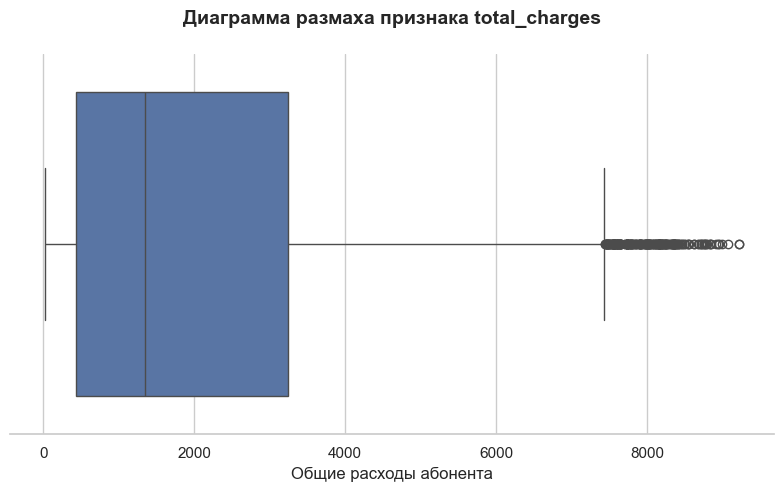

In [58]:
print_boxplot(
    contract['total_charges'],
    title='Диаграмма размаха признака total_charges',
    x_label='Общие расходы абонента'
)

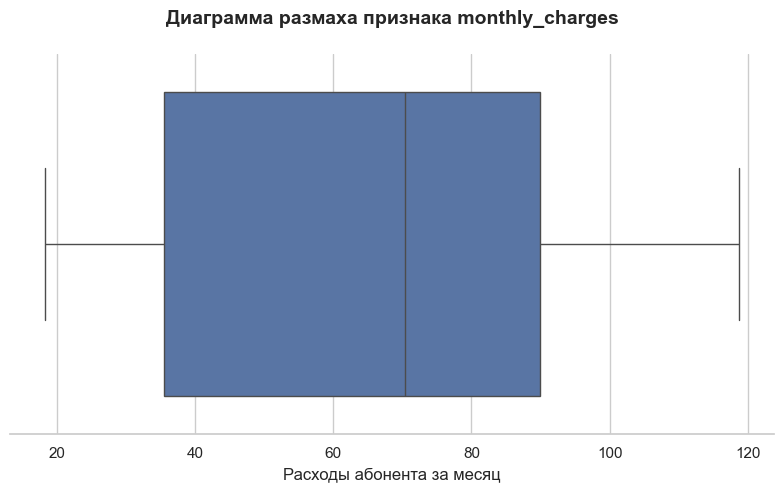

In [59]:
print_boxplot(
    contract['monthly_charges'],
    title='Диаграмма размаха признака monthly_charges',
    x_label='Расходы абонента за месяц'
)

### Таблица `personal`

In [60]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [61]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
5407,9786-YWNHU,Female,0,Yes,Yes
2336,3211-ILJTT,Male,0,Yes,No
5063,3744-ZRRDZ,Male,0,No,No
1516,6198-RTPMF,Female,0,Yes,No
1869,7010-BRBUU,Male,0,Yes,Yes


Нейминг столбцов не соответствует принтым соглашениям.

In [62]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [63]:
print('Количество уникальных значений в:')
for column in personal:
    print(f'\t{column}: {personal[column].nunique()}')

Количество уникальных значений в:
	customer_id: 7043
	gender: 2
	senior_citizen: 2
	partner: 2
	dependents: 2


In [64]:
print('Уникальные значения в:')
for column in personal.columns[1:]:
    print(f'\t{column}: {personal[column].unique()}')

Уникальные значения в:
	gender: ['Female' 'Male']
	senior_citizen: ['0' '1']
	partner: ['Yes' 'No']
	dependents: ['No' 'Yes']


В признаке `senior_citizen` лежат значения '0' и '1'. Это не очень удобно для дальнейшей визуализации. Поменяем их на `Yes/No`.

In [65]:
# перезаписываем признак 
personal['senior_citizen'] = personal['senior_citizen'].apply(
    lambda x: 'Yes' if x == '1' else 'No'
)

In [66]:
# проверка результата
print('Уникальные значения в:')
for column in personal.columns[1:]:
    print(f'\t{column}: {personal[column].unique()}')

Уникальные значения в:
	gender: ['Female' 'Male']
	senior_citizen: ['No' 'Yes']
	partner: ['Yes' 'No']
	dependents: ['No' 'Yes']


### Таблица `phone`

In [67]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [68]:
phone.sample(5)

,CustomerId,MultipleLines
5311,4118-CEVPF,Yes
6186,9940-HPQPG,Yes
4933,3512-IZIKN,Yes
2463,2466-NEJOJ,No
2090,6140-QNRQQ,No


Нейминг столбцов не соответствует принтым соглашениям.

In [69]:
phone.columns = ['customer_id', 'multiple_lines']

In [70]:
print('Количество уникальных значений в:')
for column in phone:
    print(f'\t{column}: {phone[column].nunique()}')

Количество уникальных значений в:
	customer_id: 6361
	multiple_lines: 2


In [71]:
print('Уникальные значения в:')
for column in phone.columns[1:]:
    print(f'\t{column}: {phone[column].unique()}')

Уникальные значения в:
	multiple_lines: ['No' 'Yes']


### Таблица `internet`

In [72]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [73]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
778,7294-TMAOP,Fiber optic,No,No,No,No,Yes,Yes
5306,8450-JOVAH,DSL,Yes,No,No,No,No,No
4907,3422-GALYP,Fiber optic,No,Yes,No,No,No,No
545,5760-IFJOZ,Fiber optic,No,Yes,Yes,No,Yes,Yes
1673,8311-UEUAB,DSL,Yes,No,No,No,Yes,Yes


Нейминг столбцов не соответствует принтым соглашениям.

In [74]:
internet.columns = [
    'customer_id', 'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
]

In [75]:
print('Количество уникальных значений в:')
for column in internet:
    print(f'\t{column}: {internet[column].nunique()}')

Количество уникальных значений в:
	customer_id: 5517
	internet_service: 2
	online_security: 2
	online_backup: 2
	device_protection: 2
	tech_support: 2
	streaming_tv: 2
	streaming_movies: 2


In [76]:
print('Уникальные значения в:')
for column in internet.columns[1:]:
    print(f'\t{column}: {internet[column].unique()}')

Уникальные значения в:
	internet_service: ['DSL' 'Fiber optic']
	online_security: ['No' 'Yes']
	online_backup: ['Yes' 'No']
	device_protection: ['No' 'Yes']
	tech_support: ['No' 'Yes']
	streaming_tv: ['No' 'Yes']
	streaming_movies: ['No' 'Yes']


### Промежуточные выводы по исследованию таблиц

- в поле `total_charges` таблицы `contract` есть значения, превышающие Q3 + 1.5 IQR. Но эти значения не являются аномальными и вполне допустимы. С выбросами и аномалиями проблем нет
- несоответствия типов данных были обработаны
- пропуски, полученные после приведения к типу `datetime` в поле `end_date` означают, что договор еще действует
- количество уникальных значений ID клиентов соответствует количеству записей в таблицах, что говорит об отсутствии дубликатов
- нейминг столбцов был приведен в соответствие принятым соглашениям
- неявных пропусков в категориальных принаках нет
- даты начала действия договоров лежат в диапазоне от `2013-10-01` до `2020-02-01`
- даты начала окончания действия договоров лежат в диапазоне от `2014-06-01` до `2020-01-01`
- количество завершивших действие договоров составляют 16 % от общего количества

### Объединение таблиц

In [77]:
# объединяем таблицы методом merge 
# для personal указываем inner
# для остальных указывваем left чтобы не потерять данные
data = contract \
    .merge(personal, on='customer_id', how='inner') \
    .merge(phone, on='customer_id', how='left') \
    .merge(internet, on='customer_id', how='left')

In [78]:
# проверяем результат
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     6361 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

Все записи из всех таблиц перенесены в итоговый датасет.

### Интерпретация и обработка пропусков после объединения таблиц

В результате объединения в результирующей таблице появились пропуски в данных. Это объясняется тем, что не все пользователи есть в таблицах `phone` и `internet`. Вероятнее всего, пользователи, которые есть в в таблицах `personal` и `contract`, но нет в таблицах `phone` и `internet` просто не пользуются этими услугами (остается, например, TV или мобильная связь). Тогда по тоношению к данным корректно было заполнить все недостающие значения заглушкой `Other`.

In [79]:
# заполняем пропуски во всех полях, кроме end_date
data = data.fillna(
    {key: 'Not applicable' for key in data.columns if key != 'end_date'}
)

In [80]:
# проверка результата
data.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
dtype: int64

### Выделение целевой переменной

Создадим целевой признак. Если срок действия договора закончился - это целевой клиент (1), если даты окончания нет, значит договор действует (0).

In [81]:
# используем метод assign
data = data.assign(
    target=lambda x: pd.notna(x['end_date']).astype(int)
)

In [82]:
# проверяем результат
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

### Конструирование нового признака

Рассчитаем длительность контракта для каждого абонента (`contract_duration`) как разницу в днях между датой окончания срока действия и начала. Если контракт не завершен, то окончанием срока будем считать 1 февраля 2020 года (дата атуальности информации о договорах).

In [83]:
# заполняем пропущенные значения в поле end_date
data['end_date'] = data['end_date'].fillna(pd.Timestamp('2020-02-01'))

In [84]:
# проверяем результат
data['end_date'].isna().sum()

0

In [85]:
# получаем временной сдвиг и выделяем количество дней
data['contract_duration'] = (data['end_date'] - data['begin_date']).dt.days

### Исследовательский анализ объединенных данных c учетом целевой переменной

Проверим распределение целевой переменной.

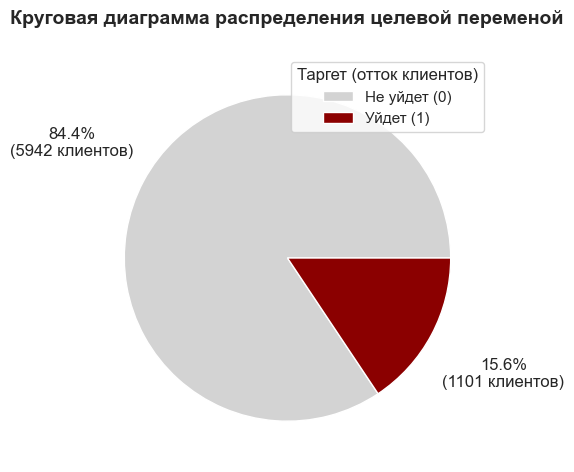

In [86]:
# выводим круговую диаграмму
print_pie(
    data.target,
    title='Круговая диаграмма распределения целевой переменой'
)

Целевая переменная несбалансирована.

Посмотрим как распределены количественные признаки с учетом целевой переменной. Для нивелирования дисбаланса классов будем использовать график `kde` с параметром `common_norm=False`, чтобы распределения нормаровались к 1 отдельно внутри своих групп.

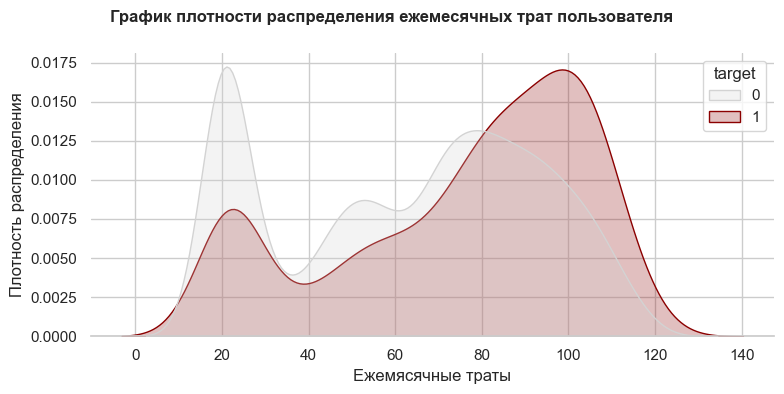

In [87]:
# выводим распределение ежемесячных трат пользователя
print_distribution_density(
    df=data,
    col_name='monthly_charges',
    title='График плотности распределения ежемесячных трат пользователя',
    x_label='Ежемясячные траты',
    hue='target'
)

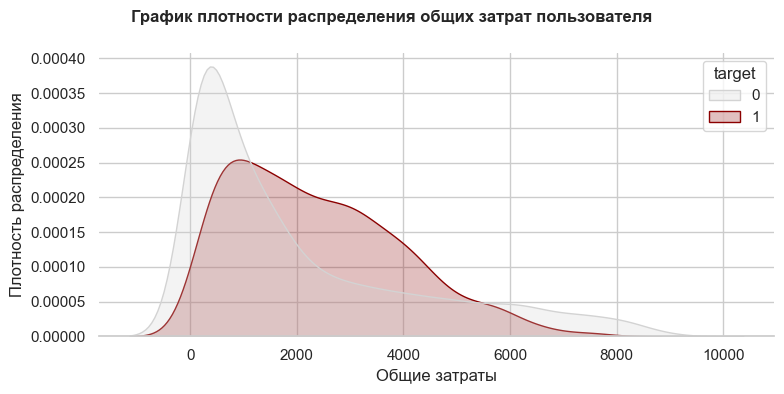

In [88]:
# выводим распределение общих трат пользователя
print_distribution_density(
    df=data,
    col_name='total_charges',
    title='График плотности распределения общих затрат пользователя',
    x_label='Общие затраты',
    hue='target'
)

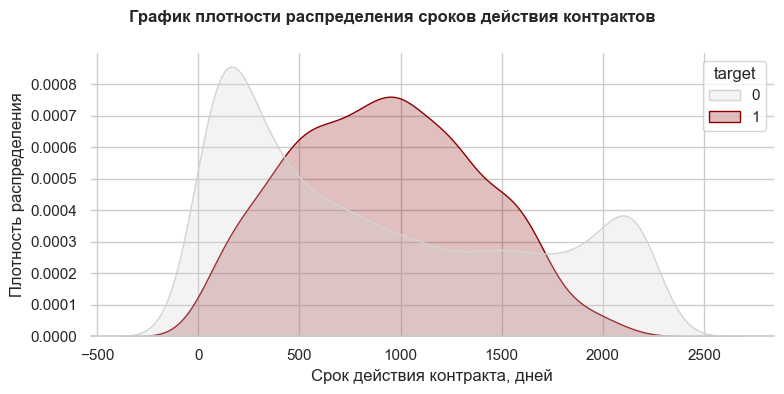

In [89]:
# выводим распределение количества дней
print_distribution_density(
    df=data,
    col_name='contract_duration',
    title='График плотности распределения сроков действия контрактов',
    x_label='Срок действия контракта, дней',
    hue='target'
)

Посмотрим как распределены категориальные признаки с учетом целевой переменной. Для каждого признака выводим количественную диаграмму.

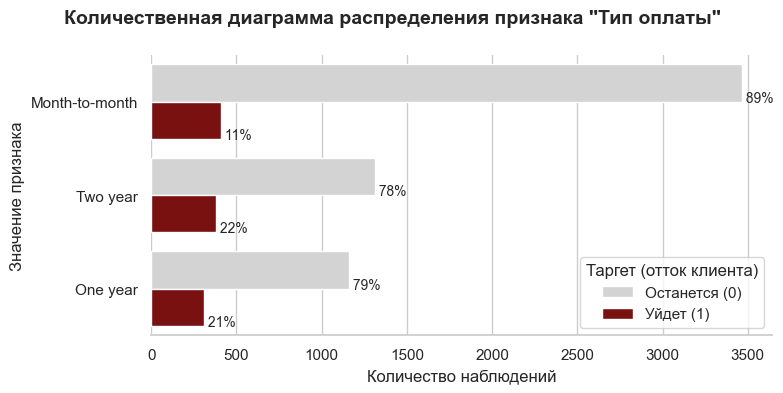

In [90]:
print_counts(
    df=data,
    col_name='type',
    title='Количественная диаграмма распределения признака "Тип оплаты"'
)

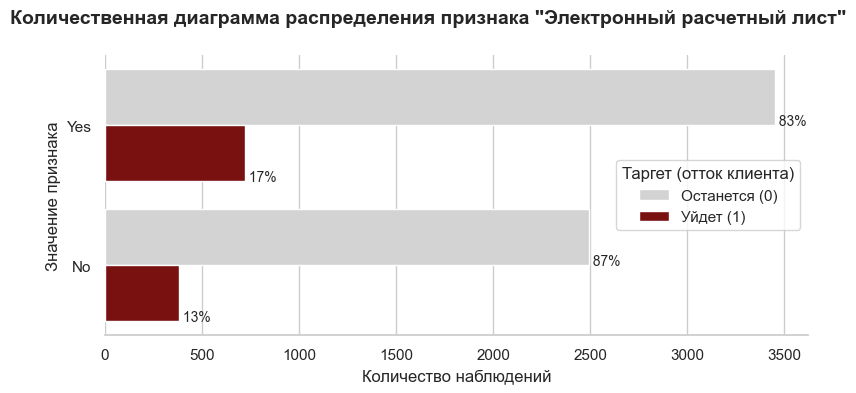

In [91]:
print_counts(
    df=data,
    col_name='paperless_billing',
    title='Количественная диаграмма распределения признака "Электронный расчетный лист"'
)

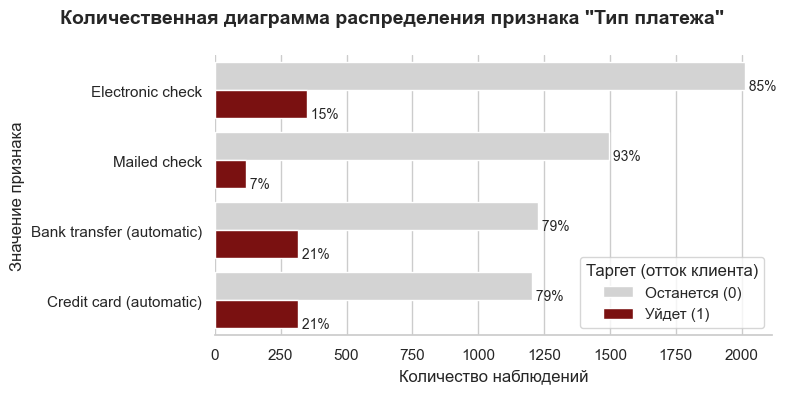

In [92]:
print_counts(
    df=data,
    col_name='payment_method',
    title='Количественная диаграмма распределения признака "Тип платежа"'
)

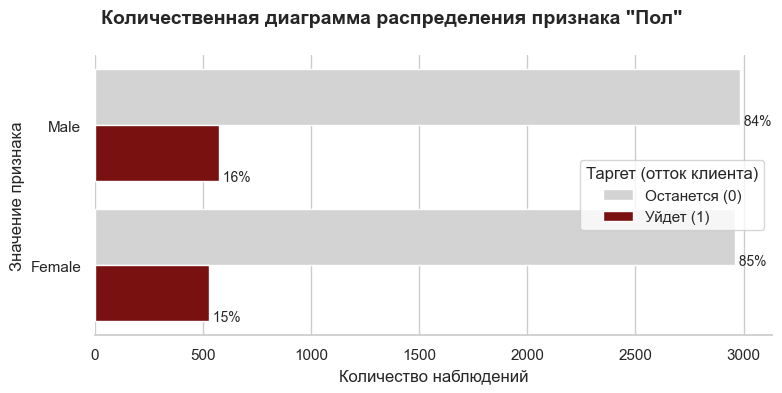

In [93]:
print_counts(
    df=data,
    col_name='gender',
    title='Количественная диаграмма распределения признака "Пол"'
)

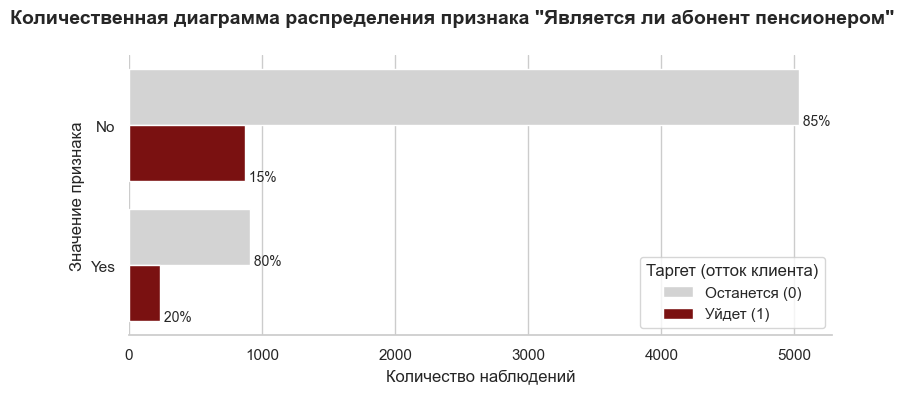

In [94]:
print_counts(
    df=data,
    col_name='senior_citizen',
    title='Количественная диаграмма распределения признака "Является ли абонент пенсионером"'
)

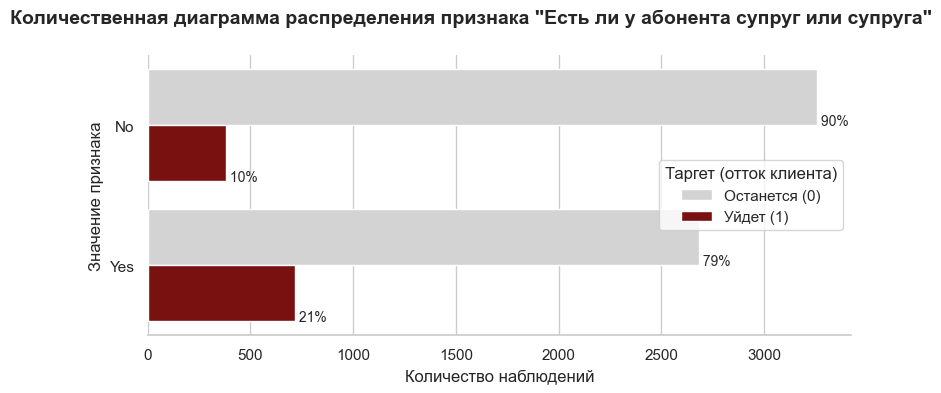

In [95]:
print_counts(
    df=data,
    col_name='partner',
    title='Количественная диаграмма распределения признака "Есть ли у абонента супруг или супруга"'
)

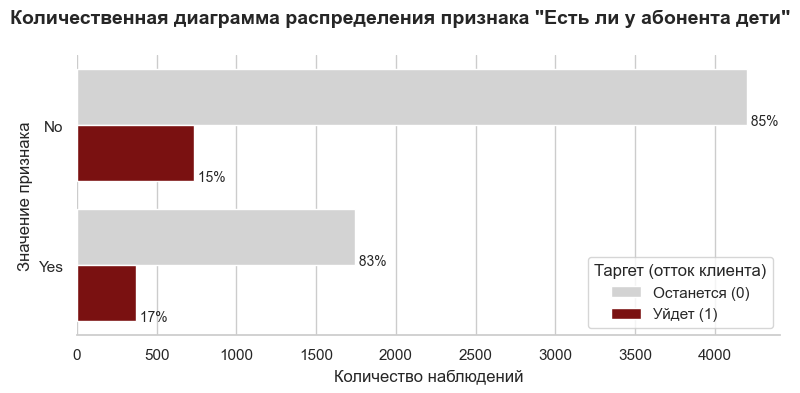

In [96]:
print_counts(
    df=data,
    col_name='dependents',
    title='Количественная диаграмма распределения признака "Есть ли у абонента дети"'
)

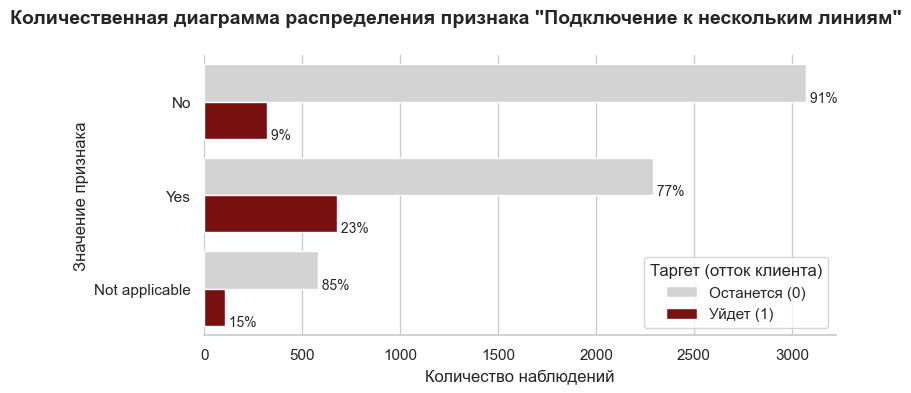

In [97]:
print_counts(
    df=data,
    col_name='multiple_lines',
    title='Количественная диаграмма распределения признака "Подключение к нескольким линиям"'
)

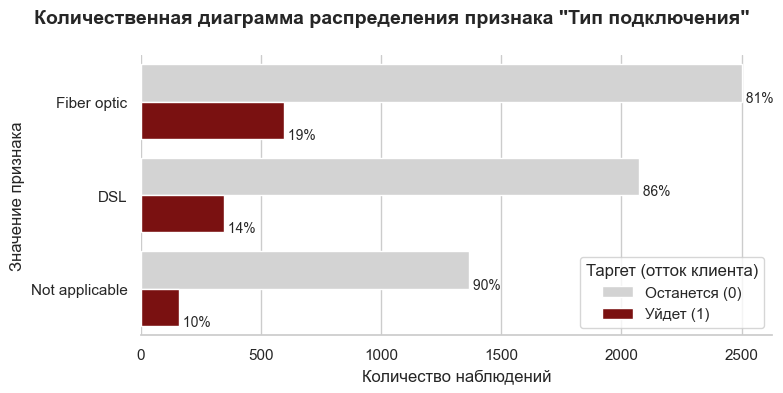

In [98]:
print_counts(
    df=data,
    col_name='internet_service',
    title='Количественная диаграмма распределения признака "Тип подключения"'
)

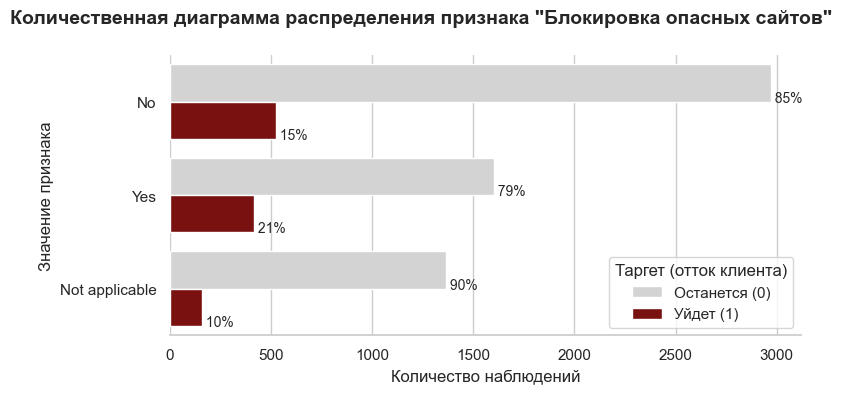

In [99]:
print_counts(
    df=data,
    col_name='online_security',
    title='Количественная диаграмма распределения признака "Блокировка опасных сайтов"'
)

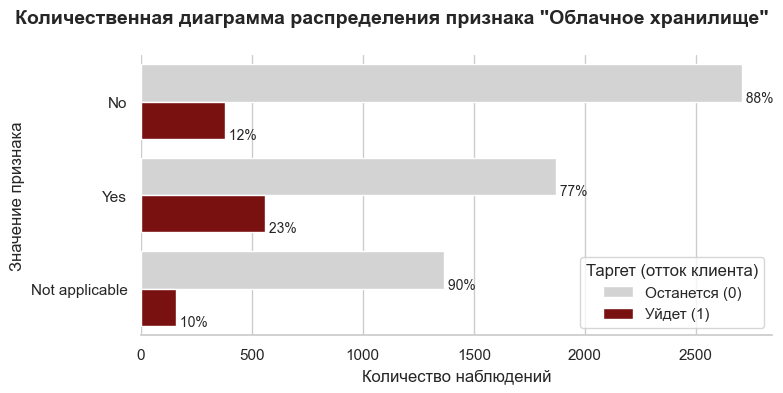

In [100]:
print_counts(
    df=data,
    col_name='online_backup',
    title='Количественная диаграмма распределения признака "Облачное хранилище"'
)

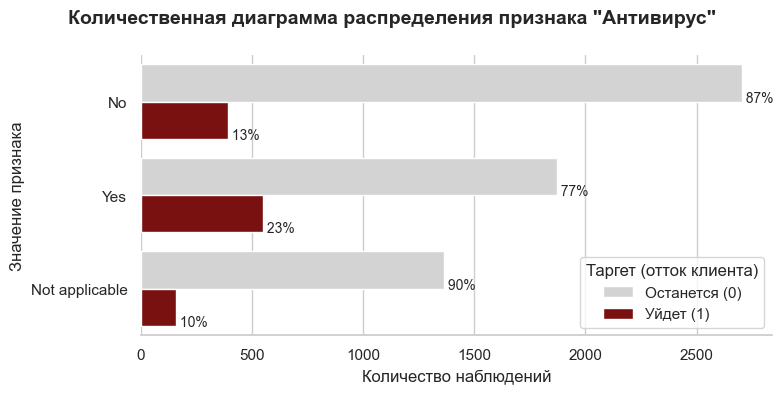

In [101]:
print_counts(
    df=data,
    col_name='device_protection',
    title='Количественная диаграмма распределения признака "Антивирус"'
)

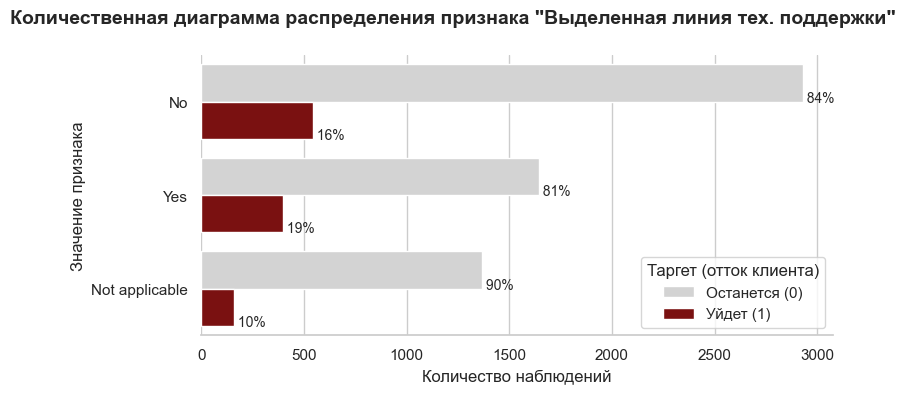

In [102]:
print_counts(
    df=data,
    col_name='tech_support',
    title='Количественная диаграмма распределения признака "Выделенная линия тех. поддержки"'
)

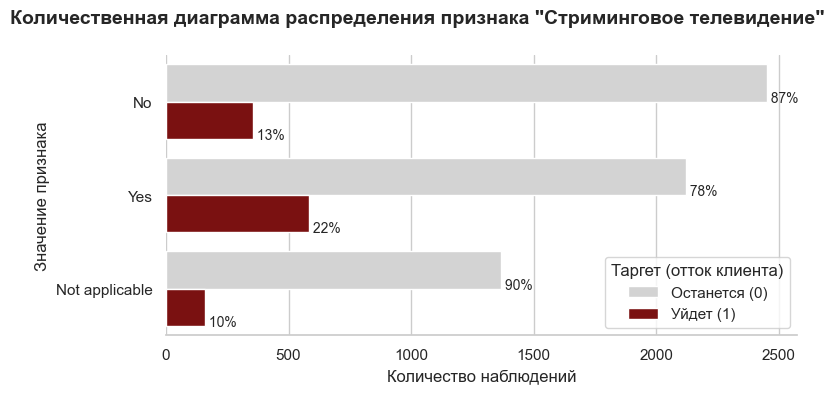

In [103]:
print_counts(
    df=data,
    col_name='streaming_tv',
    title='Количественная диаграмма распределения признака "Стриминговое телевидение"'
)

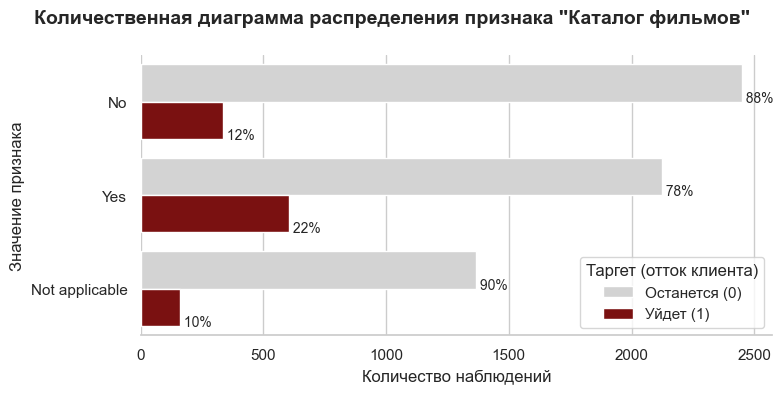

In [104]:
print_counts(
    df=data,
    col_name='streaming_movies',
    title='Количественная диаграмма распределения признака "Каталог фильмов"'
)

Посмотрим на корреляцию признаков.

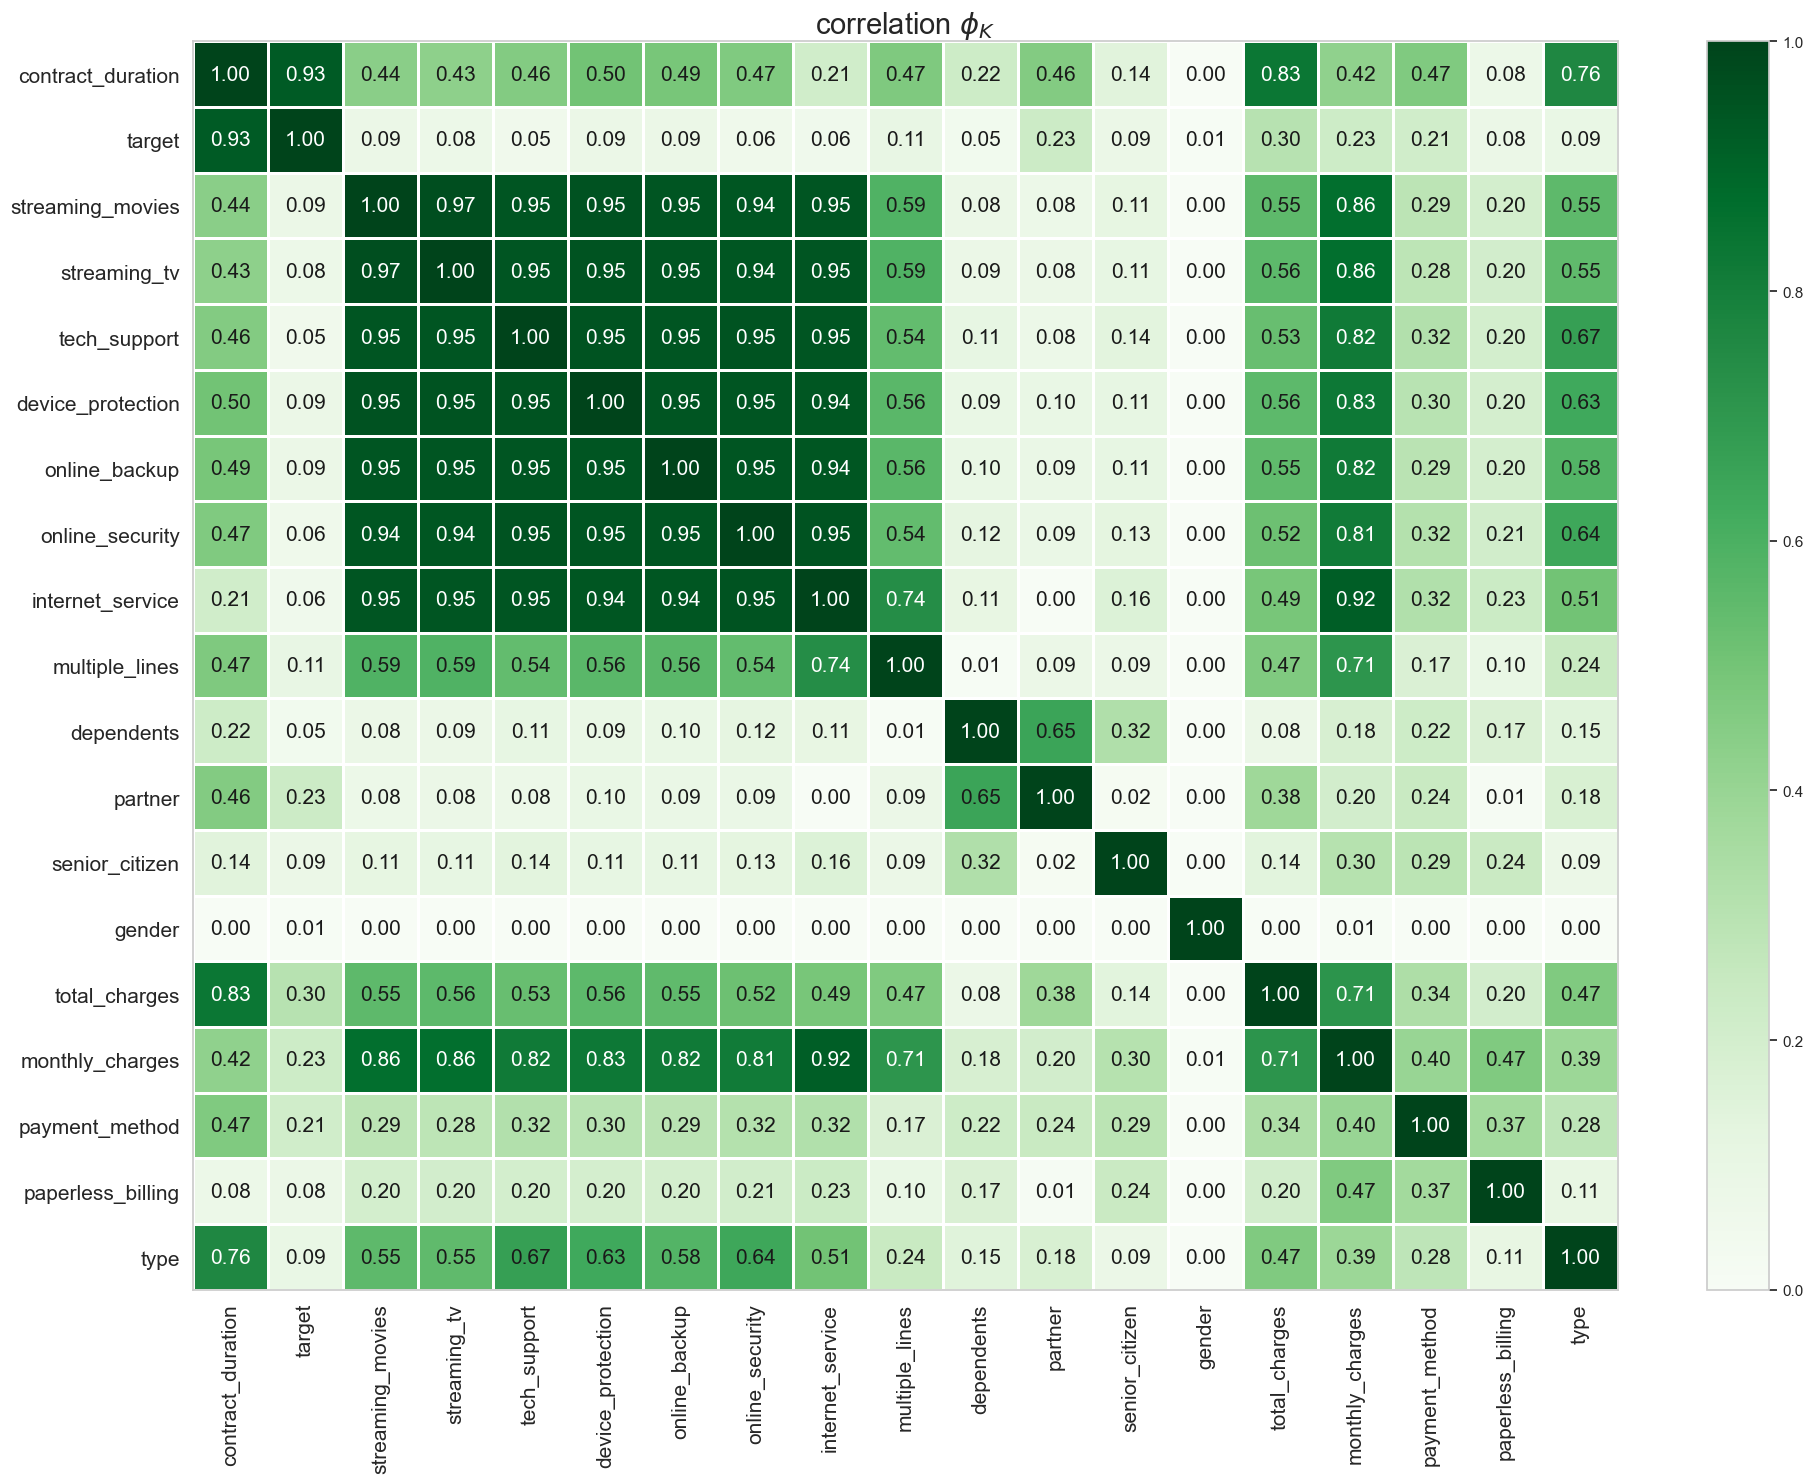

In [105]:
plot_corr(
    data \
        .drop('customer_id', axis=1) \
        .drop('begin_date', axis=1) \
        .drop('end_date', axis=1),
    interval_cols=['monthly_charges', 'total_charges']
)

### Выводы по исследовательскому анализу

- целевая переменная несбалансирована, нужно использовать `class_weight='balanced'` и стратификацию при делении выборки
- лучше всего целевую переменную объясняет признак __Длительность контракта__
- признак __Пол__ никак не коррелирует с целевой переменной и не имеет различий в количественном распределении по целевой переменной
- в остальных признаках есть небольшая корреляция с целевой переменной

## Отбор признаков и подготовка данных

In [106]:
# установка 'customer_id' в индекс
data = data.set_index('customer_id')

In [107]:
# инициализируем список признаков
# убираем те, которые не будут использоваться для обучения модели
features = [
    #'begin_date', 
    #'end_date',
    'type',
    'paperless_billing',
    'payment_method',
    'monthly_charges',
    'total_charges',
    #'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    #'target',
    'contract_duration'
]

In [108]:
# деление выборки
X, X_test, y, y_test = train_test_split(
    data[features],
    data['target'],
    test_size=TEST_SIZE, # 0.25
    random_state=RANDOM_STATE,
    stratify=data['target']
)

In [109]:
# проверяем размерности
print(f'''Размерность X_train: {X.shape}
Размерность y_train: {y.shape}
Размерность X_test: {X_test.shape}
Размерность y_test: {y_test.shape}''')

Размерность X_train: (5282, 17)
Размерность y_train: (5282,)
Размерность X_test: (1761, 17)
Размерность y_test: (1761,)


## Обучение моделей и подбор гиперпараметров

Разделим признаки на количественные и категориальные.

In [110]:
# список с названиями категориальных признаков
cat_columns = [
    'type',
    'paperless_billing',
    'payment_method',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]

In [111]:
# список с названиями количественных признаков
num_columns = [
    'monthly_charges',
    'total_charges',
    'contract_duration'
]

В работе будем испоьзовать 3 модели:
- __RandomForestClassifier__
- на основе бустинга __LGBMClassifier__
- нейронная сеть на основе __TensorFlow__

Подбор гиперпараметров будем осуществлять с помощью инструмента `optuna` с использованием кросс-валидации на 5 фолдов.

In [112]:
# инициализируем инструмент для кросс валидации
cv = StratifiedKFold(
    n_splits=CV_N_SPLITS, # 5 фолдов
    shuffle=True,
    random_state=RANDOM_STATE
)

### RandomForestClassifier

Для модели на основе дерева решений будем использовать только кодирование категориальных переменных.

In [113]:
# создаём ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('te', TargetEncoder(), cat_columns),
    ],
    remainder='passthrough'
)

In [114]:
# инициализируем словарь распределения гиперпараметров
rfc_param_dist = {
    'model__max_depth': optuna.distributions.IntDistribution(10, 100),
    'model__min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'model__min_samples_leaf': optuna.distributions.IntDistribution(2, 20),
    'model__max_features': optuna.distributions.IntDistribution(2, 20),
    'preprocessor__te__smoothing': optuna.distributions.IntDistribution(5, 20)
}

In [115]:
# создаем объект study и передаем параметр direction='maximize'
# чтобы максимизировать метрику
rfc_study = optuna.create_study(direction='maximize')

[I 2025-04-10 17:59:20,879] A new study created in memory with name: no-name-6d1ee251-ccdd-4741-8e85-e8277711f4fe


In [116]:
# настраиваем OptunaSearchCV
rfc_optuna_search = OptunaSearchCV(
    estimator=Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ))
    ]),
    param_distributions=rfc_param_dist,
    scoring='roc_auc',
    cv=cv,
    study=rfc_study,
    n_trials=150,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

/var/folders/qv/wk9zg6v91q71qbqr0k2c5phh0000gn/T/ipykernel_21440/1511990651.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rfc_optuna_search = OptunaSearchCV(


In [117]:
# запускаем поиск гиперпараметров с замером времени, убираем логи
logging.getLogger("optuna").setLevel(logging.CRITICAL)

# запускаем поиск лучших гиперпараметров
rfc_optuna_search.fit(X, y)

OptunaSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('te',
                                                                           TargetEncoder(),
                                                                           ['type',
                                                                            'paperless_billing',
                                                                            'payment_method',
                                                                            'senior_citizen',
                                                                            'partner',
                                                                            'dependents',
                                                                            'multiple_lines',
                                                                            'internet_service',
                                                                            'online_security',
                                                                            'online_backup',...
                                    'model__max_features': IntDistribution(high=20, log=False, low=2, step=1),
                                    'model__min_samples_leaf': IntDistribution(high=20, log=False, low=2, step=1),
                                    'model__min_samples_split': IntDistribution(high=20, log=False, low=2, step=1),
                                    'preprocessor__te__smoothing': IntDistribution(high=20, log=False, low=5, step=1)},
               random_state=42, scoring='roc_auc',
               study=<optuna.study.study.Study object at 0x33aeb7760>,
               verbose=-1)

In [118]:
# лучшие найденные гиперпараметры
rfc_study.best_params

{'model__max_depth': 93,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 13,
 'model__max_features': 11,
 'preprocessor__te__smoothing': 11}

### LGBMClassifier

In [119]:
# создаём ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('te', TargetEncoder(), cat_columns),
    ],
    remainder='passthrough'
)

In [120]:
# инициализируем словарь распределения гиперпараметров
lgb_param_dist = {
    'model__num_leaves': optuna.distributions.IntDistribution(20, 50),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1),
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000),
    'preprocessor__te__smoothing': optuna.distributions.IntDistribution(5, 20)
}

In [121]:
# создаем объект study и передаем параметр direction='maximize'
# чтобы максимизировать метрику
lgb_study = optuna.create_study(direction='maximize')

In [122]:
# настраиваем OptunaSearchCV
lgb_optuna_search = OptunaSearchCV(
    estimator=Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1, verbose=-1,
            objective='binary',
            class_weight='balanced'
        ))
    ]),
    param_distributions=lgb_param_dist,
    scoring='roc_auc',
    cv=cv,
    study=lgb_study,
    n_trials=50,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

/var/folders/qv/wk9zg6v91q71qbqr0k2c5phh0000gn/T/ipykernel_21440/3942271707.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgb_optuna_search = OptunaSearchCV(


In [123]:
# убираем логи
logging.getLogger('optuna').setLevel(logging.CRITICAL)

# запускаем поиск лучших гиперпараметров
lgb_optuna_search.fit(X, y)

OptunaSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('te',
                                                                           TargetEncoder(),
                                                                           ['type',
                                                                            'paperless_billing',
                                                                            'payment_method',
                                                                            'senior_citizen',
                                                                            'partner',
                                                                            'dependents',
                                                                            'multiple_lines',
                                                                            'internet_service',
                                                                            'online_security',
                                                                            'online_backup',...
               param_distributions={'model__learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None),
                                    'model__n_estimators': IntDistribution(high=1000, log=False, low=100, step=1),
                                    'model__num_leaves': IntDistribution(high=50, log=False, low=20, step=1),
                                    'preprocessor__te__smoothing': IntDistribution(high=20, log=False, low=5, step=1)},
               random_state=42, scoring='roc_auc',
               study=<optuna.study.study.Study object at 0x33bbb2460>,
               verbose=-1)

In [124]:
# лучшие найденные гиперпараметры
lgb_study.best_params

{'model__num_leaves': 20,
 'model__learning_rate': 0.07002001241921012,
 'model__n_estimators': 439,
 'preprocessor__te__smoothing': 13}

### Нейронная сеть на основе TensorFlow

In [125]:
# фиксация генераторов случайных чисел для воспроизводимости
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [126]:
# функция для инициализации нейронной сети
def init_neural_net(input_size,
                    hidden_size_1=256,
                    hidden_size_2=128,
                    dropout=0.3,
                    init_weights_stddev=0.1):
    
    model = Sequential([
        Input(shape=(input_size,)),
        # первый скрытый слой
        Dense(
            hidden_size_1,
            activation='silu',
            kernel_regularizer=l2(1e-3),
            kernel_initializer=RandomNormal(mean=0.0, stddev=init_weights_stddev)
        ),  
        BatchNormalization(),
        Dropout(dropout),
        # второй скрытый слой
        Dense(
            hidden_size_2,
            activation='silu',
            kernel_regularizer=l2(1e-3),
            kernel_initializer=RandomNormal(mean=0.0, stddev=init_weights_stddev)
        ),
        BatchNormalization(),
        Dropout(dropout),
        # выходной классификационный слой
        Dense(
            1,
            activation='sigmoid',
            kernel_initializer=RandomNormal(mean=0.0, stddev=init_weights_stddev)
        )  # выходное значение от 0 до 1
    ])

    model.compile(
        optimizer=Adam(learning_rate=LR),
        loss='binary_crossentropy',  # для бинарной классификации
        metrics=[tf.keras.metrics.AUC(name='roc_auc')]  # добавляем ROC-AUC
    )    

    return model


In [127]:
# функция для обучения нейронной сети
def train_net(model, X_train, y_train, X_valid, y_valid):
    # Callbacks для динамического уменьшения скорости обучения
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    # создаём ColumnTransformer для подготовки данных
    preprocessor = ColumnTransformer(
        transformers=[
            ('te', TargetEncoder(), cat_columns),
            ('num', MinMaxScaler(), num_columns)
        ],
        remainder='passthrough'
    )

    X_train_prepaired = preprocessor.fit_transform(X_train, y_train)
    X_valid_prepaired = preprocessor.transform(X_valid)

    # запуск обучения
    history = model.fit(
        X_train_prepaired, y_train, # данные для обучения
        validation_data=(X_valid_prepaired, y_valid),  # валидационные данные
        epochs=EPOCH_NUM, # количество эпох
        batch_size=BATCH_SIZE, # размер батча
        callbacks=[reduce_lr], # передаём ReduceLROnPlateau
        verbose=-1
    )

    return history.history['val_roc_auc'][-1] # возвращает ROC-AUC после последней эпохи

In [128]:
# функция для подбора гиперпараметров
# принимает на вход объект trial (проба) и имя модели
def objective(trial):

    # инициализация гиперпараметров
    hidden_size_1 = trial.suggest_int('hidden_size_1', 128, 512)
    hidden_size_2 = trial.suggest_int('hidden_size_2', 32, 128)
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    init_weights_stddev = trial.suggest_float('init_weights_stddev', 0.05, 0.3)
    
    roc_auc_cv = [] # список для хранения метрик для каждого cv-фолда

    # вручную получаем индексы разбиений для CV
    for train_idx, valid_idx in cv.split(X, y):

        # инициализация модели с предложенными гиперпараметрами
        model = init_neural_net(
            input_size=X.shape[1],
            hidden_size_1=hidden_size_1,
            hidden_size_2=hidden_size_2,
            dropout=dropout,
            init_weights_stddev=init_weights_stddev
        )
        # запуск обучения модели
        roc_auc = train_net(
            model=model,
            X_train=X.iloc[train_idx],
            y_train=y.iloc[train_idx],
            X_valid=X.iloc[valid_idx],
            y_valid=y.iloc[valid_idx]
        )
        roc_auc_cv.append(roc_auc) # сохраняем текущий roc-auc

    return np.mean(roc_auc_cv) # возвращаем среднее значение метрики на CV

In [129]:
# запускаем поиск гиперпараметров с замером времени, убираем логи
logging.getLogger("optuna").setLevel(logging.CRITICAL)
nn_study = optuna.create_study(direction='maximize')
nn_study.optimize(objective, n_trials=5)

2025-04-10 18:10:31.297327: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-10 18:10:31.297358: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-10 18:10:31.297367: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-10 18:10:31.297398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-10 18:10:31.297409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-04-10 18:10:31.804316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 29/50
Epoch 30/50
Epoch 31/50

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 32/50
Epoch 33/50
Epoch 34/50

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50

Epoch 40: ReduceLROnPlateau reducing learning rate to 7.812499825377017

In [130]:
# сравнение ROC-AUC на кросc-валидации для терх моделей
print(f'RandomForestClassifier ROC-AUC{np.round(rfc_optuna_search.best_score_, 3)}')
print(f'TensorFlow NN ROC-AUC {np.round(nn_study.best_value, 3)}')
print(f'LGBMClassifier ROC-AUC {np.round(lgb_optuna_search.best_score_, 3)}')

RandomForestClassifier ROC-AUC0.832
TensorFlow NN ROC-AUC 0.831
LGBMClassifier ROC-AUC 0.894


По результатам кросс-валидации лучший результат показала модель на основе бустинга - __LGBMClassifier__

## Тестирование модели

In [131]:
# получаем пронозы меток классов для модели
# с лучшими найденными гиперпараметрами
y_pred = lgb_optuna_search.predict(X_test)

In [132]:
# получаем вероятности приназдлежности к классам
y_probs = lgb_optuna_search.predict_proba(X_test)[:, 1]

In [133]:
# считаем метррики качества                                    
print(f'ROC-AUC на тесте: {np.round(roc_auc_score(y_test, y_probs), 3)}')
print(f'ACCURACY на тесте: {np.round(accuracy_score(y_test, y_pred), 3)}')
print(f'PRECISION на тесте: {np.round(precision_score(y_test, y_pred), 3)}')
print(f'RECALL на тесте: {np.round(recall_score(y_test, y_pred), 3)}')

ROC-AUC на тесте: 0.898
ACCURACY на тесте: 0.893
PRECISION на тесте: 0.641
RECALL на тесте: 0.72


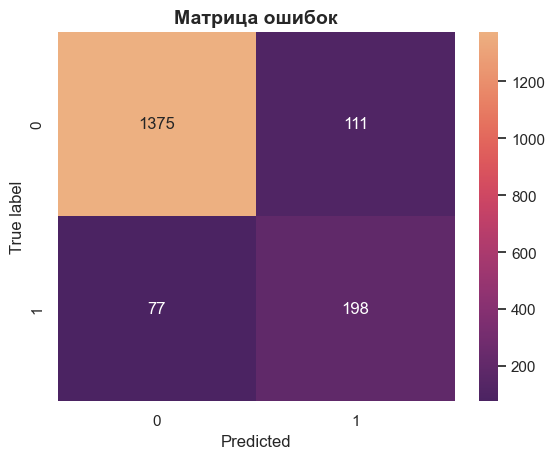

In [134]:
# выводим матрицу ошибок
print_confusion_matrix(y_test, y_pred)

Для более детального анализа посторим графики ROC-кривой и PR-кривой.

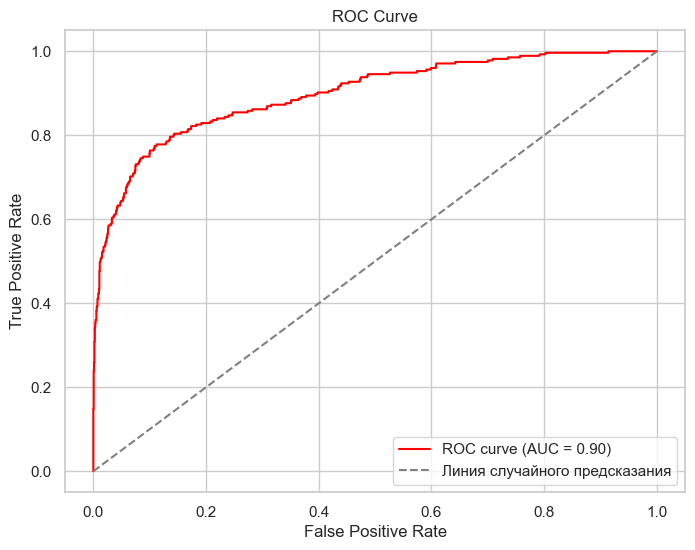

In [135]:
# получаем FPR, TPR и пороги для построения ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# визуализация ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc_score(y_test, y_probs):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Линия случайного предсказания')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

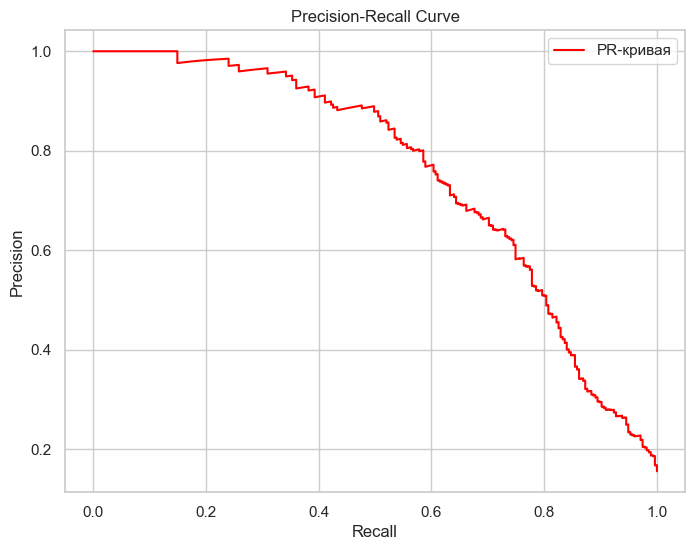

In [136]:
# получаем данные для построения PR-кривой
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# визуализация PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', label="PR-кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### Выводы по тестированию модели

1. __ROC-AUC = 0.898__ - это значение говорит нам о том, что если взять случайным образом 2 абонентов, одного "ушедшего", второго нет, то с вероятностью почти 0.9 "ушедшему" будет присвоена бОльшая вероятность старшего класса. Данная метрика не показывает количественное распределение присвоенных меток класса.

2. __Accuracy = 0.893__ - это доля всех правильно предсказанных клиентов (и остающихся, и уходящих). Если отток редкий (например, 10% клиентов уходят), модель может просто предсказывать "остался" (0) и получать высокий accuracy. Нужно смотреть Precision и Recall для лучшей оценки.
	
3. __Precision = 0.641__ - из всех клиентов, которых модель пометила как "уйдут", около 64% действительно уходят. Это важно, если компания хочет не тратить ресурсы на ложные срабатывания (не уговаривать остающихся клиентов).

4. __Recall = 0.72__ - Recall показывает, сколько реальных оттоков из их общего числа модель поймала. Только около 72% уходящих клиентов распознаны. Это плохо, если бизнес хочет спасать максимум клиентов!

5. __Интерпретация матрицы ошибок:__

- TP (True Positive) — в 198 случаях из 275 модель правильно предсказала отток клиента.
- FP (False Positive) — в 77 из 275 случаях модель ошибочно предсказала отток клиента.
- FN (False Negative) — в 111 случаях из 1486 модель ошибочно предсказала, что клиент останется.
- TN (True Negative) — в 1375 случаях из 1486 модель правильно предсказала что клиент останется.

## Оценка важности признаков

Проведем оценку важности признаков по SHAP-диаграмме.

In [137]:
# подготовка данных (train)
X_transformed = pd.DataFrame(
    data = lgb_optuna_search.best_estimator_['preprocessor'].transform(X),
    columns = lgb_optuna_search.best_estimator_['preprocessor'].get_feature_names_out()
)

 96%|=================== | 5095/5282 [00:28<00:01]       

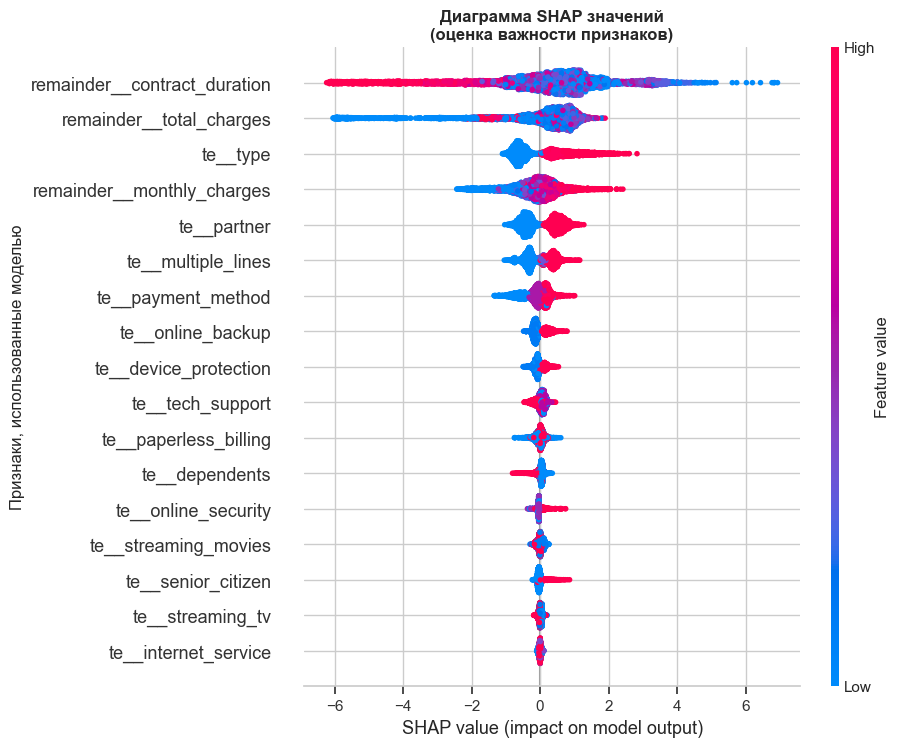

In [138]:
# построим диаграмму SHAP‑значений
plot_shap_beeswarm(
    model=lgb_optuna_search.best_estimator_['model'],
    X=X_transformed
)

Самым важным признаком для модели является __Срок действия контракта__. Из SHAP-диаграммы видно, что чем больше клиент остается с компанией , тем меньше вероятность его ухода в дальнейшем.

## Выводы по проекту

### Главная задача проекта:

На основе данных об абонентах спроектировать модель, которая будет предсказывать, разорвёт ли договор пользования услугами связи или нет (задача бинарной классификации).

### Краткий обзор проделанной работы

- загрузка и ознакомление с данными из SQLite
- предварительная обработка
- исследовательский анализ
- разработка новых синтетических признаков
- проверка на мультиколлинеарность
- отбор финального набора обучающих признаков
- выбор и обучение моделей
- подбор гиперпараметров
- тестирование лучшей модели, выбранной по результатам кросс-валидации
- интрерпретация результатов

### Полученные результаты:

Лучшие результаты на кросс-валидации показала модель на основе бустинга - __LGBMClassifier__

При оценке качества модели на тестовой выборке получены следующие метрики:
- __ROC-AUC: 0.898__ - высокое качество ранжирования вероятностей
- __ACCURACY: 0.893__ - доля всех правильно предсказанных клиентов (и остающихся, и уходящих)
- __PRECISION: 0.641__ - модель делает мало ложных тревог
- __RECALL: 0.72__ - модель пропускает около 28 % уходящих клиентов.

__Особенности модели:__

- высокий ROC-AUC (0.898). Модель хорошо ранжирует вероятность классов.
- средний Precision (0.641). Если модель говорит, что клиент уйдёт, она ошибается примерно в 36 % случаев.
- средний Recall (0.72). Модель пропускает примерно 28 % реальных уходящих клиентов.


### Рекомендации заказчику

1. Что можно улучшить? Повысить Recall, чтобы спасти больше клиентов. Для этого можно учитывать более низкий порог вероятности чтобы ловить больше уходящих клиентов. Например, по графику PR-кривой видно, что если необходимо ловить 80 % уходящих клиентов, то точность модели упадет до 50 %, т.е. количество ложных тревог вырастет. Если важнее не тратить ресурсы — оставить Precision выше. Если важнее не терять клиентов — увеличить Recall.

2. Исходя из результатов исследователского анализа данных и анализа важности признаков (диаграмма SHAP-значений) необходимо обращать внимание на клиентов со сроком действия контракта от 500 до 1500 дней, так как в этом диапазоне лежит наибольшая плотность уходящих клиентов. Кроме того, на сохранение клиентов благоприятно вляют невысокие расходы абонента на услуги связи.